# Use case 4: corner reflector

This section explains how to identify bursts in which the corner reflector (CR), having known geodetic coordinates, is visible, and how to get corrections at CR location.

## Notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
from scipy.interpolate import interp2d
from matplotlib import pyplot as plt

In [4]:
import s1etad
from s1etad import Sentinel1Etad, ECorrectionType

## Searching bursts in which the CR is present

Load the S1-ETAD product.

In [5]:
filename = '../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE'
eta = Sentinel1Etad(filename)

The CR position has been chosed to be in the overlab region of different bursts and swaths.

In [6]:
from shapely.geometry import Point

lat0 = +70.13  # 70° 7'48.65"N
lon0 = -76.19  # 76°11'41.55"W
h0 = 366

cr = Point(lon0, lat0)

Query for burst cobering the CR.

In [7]:
selection = eta.query_burst(geometry=cr)
selection

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
294,273,10,3,S1B_IW_SLC__1ADH_20200127T113802_20200127T1138...,IW3,2020-01-27 11:38:24.612132034,2020-01-27 11:38:27.806466524
193,275,10,2,S1B_IW_SLC__1ADH_20200127T113802_20200127T1138...,IW2,2020-01-27 11:38:26.396354902,2020-01-27 11:38:29.619467181
295,276,11,3,S1B_IW_SLC__1ADH_20200127T113827_20200127T1138...,IW3,2020-01-27 11:38:27.374799701,2020-01-27 11:38:30.569134191


## Get corrections at CR location

Reatrieve the first burst.

In [8]:
burst = next(eta.iter_bursts(selection))

Get RADAR coordinates (range and azimuth time) of the CR.

In [9]:
tau0, t0 = burst.geodetic_to_radar(lat0, lon0, h0)
tau0, t0

(array([0.00068153]), array([253.13628054]))

Get image coordinates (line and sample) of the CR.

**NOTE**: image coordinates area flaoting point numbers including pixel fractions.

In [10]:
line, sample = burst.radar_to_image(t0, tau0)
print(f'Line {line} of {burst.lines}, sample {sample} of {burst.samples}.')

Line [104.2382231] of 112, sample [10.33385208] of 462.


Get the correction.

In [11]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter='True')
data = correction['x']  # summ of corrections in the range direction

Interpolate the correction at the specified RADAR coordinates (tau0, t0).

In [12]:
azimuth_time, range_time = burst.get_burst_grid()

interpolator = interp2d(range_time, azimuth_time, data)

value_at_radar_coordinates = interpolator(tau0, t0)

print(f'The correction value at RADAR coordinates (tau0, t0) = ({tau0}, {t0}) is {value_at_radar_coordinates}')    

The correction value at RADAR coordinates (tau0, t0) = ([0.00068153], [253.13628054]) is [2.63362235]


Interpolate the correction at the specified image coordinates (line, sample).

In [13]:
xaxis = np.arange(burst.samples)
yaxis = np.arange(burst.lines)

interpolator = interp2d(xaxis, yaxis, data)

value_at_image_coordinates = interpolator(sample, line)

print(f'The correction value at image coordinates (sample, line) = ({sample}, {line}) is {value_at_image_coordinates}') 

The correction value at image coordinates (sample, line) = ([10.33385208], [104.2382231]) is [2.63362235]


## Putting all together

xy   IW3 273 [104.2382231] [10.33385208] (array([70.13]), array([-76.19]), array([345.19365682]))
time IW3 273 [0.00068153] [253.13628054] (array([70.13]), array([-76.19]), array([345.19365682]))
Interpoaltion by array coordinate [2.63362235] or time [2.63362235] should be the same
The total correction at lat/lon (70.13, -76.19) is  [2.63362235] m in range

xy   IW2 275 [42.2382231] [464.33385204] (array([70.13]), array([-76.19]), array([345.19366271]))
time IW2 275 [0.00068153] [253.13628054] (array([70.13]), array([-76.19]), array([345.19366271]))
Interpoaltion by array coordinate [3.15004682] or time [3.15004682] should be the same
The total correction at lat/lon (70.13, -76.19) is  [3.15004682] m in range

xy   IW3 276 [8.2382231] [10.33385205] (array([70.13]), array([-76.19]), array([345.19366086]))
time IW3 276 [0.00068153] [253.13628054] (array([70.13]), array([-76.19]), array([345.19366086]))
Interpoaltion by array coordinate [3.43524444] or time [3.43524444] should be the same

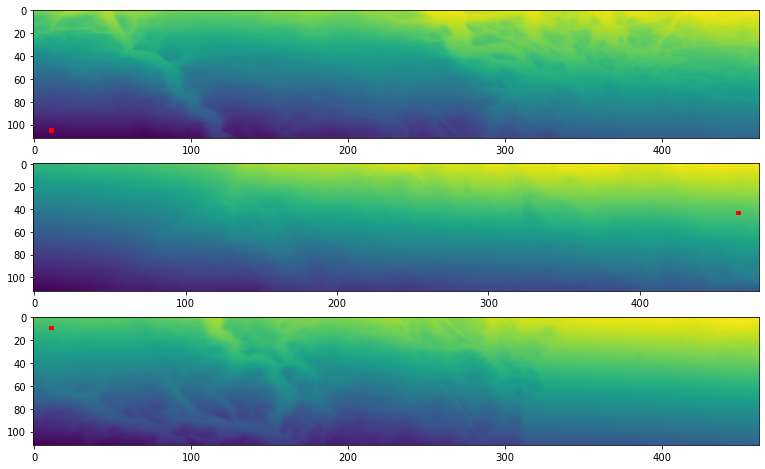

In [14]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=len(selection), ncols=1, figsize=[13, 8])

for loop, burst in enumerate(eta.iter_bursts(selection)):
    # get RADAR and image coordinates
    tau0, t0 = burst.geodetic_to_radar(lat0, lon0)
    line0, sample0 = burst.radar_to_image(t0, tau0)    
    print("xy  ", burst.swath_id, burst.burst_index, line0, sample0, burst.radar_to_geodetic(tau0, t0))
    print("time", burst.swath_id, burst.burst_index, tau0, t0, burst.radar_to_geodetic(tau0, t0))
    
    # correction
    cor = burst.get_correction(s1etad.ECorrectionType.SUM, meter='True')

    ax[loop].imshow(cor['x'], aspect='auto')
    rec_half_size = 1
    p = Rectangle((sample0 - rec_half_size, line0 - rec_half_size),
                  width=rec_half_size*2+1, height=rec_half_size*2+1,
                  color='red', fill=True)
    ax[loop].add_patch(p)

    # get the range and azimuth time axes
    azimuth_time, range_time = burst.get_burst_grid()

    # interpolate at the desired working (RADAR) coordinates
    f_t  = interp2d(range_time, azimuth_time, cor['x'])

    # get the image (lines and samples) axes
    yaxis = np.arange(azimuth_time.size)
    xaxis = np.arange(range_time.size)
    
    # interpolate at the desired working (image) coordinates
    f_ij = interp2d(xaxis, yaxis, cor['x'])
    
    print(f"Interpoaltion by array coordinate {f_ij(sample0, line0)} or time {f_t(tau0,t0)} should be the same")
    print(f"The total correction at lat/lon {lat0, lon0} is  {f_ij(sample0, line0)} m in range")
    print()

In [15]:
burst.radar_to_geodetic(tau0, t0) 

(array([70.13]), array([-76.19]), array([345.19366086]))

In [16]:
cor

{'x': array([[3.49604194, 3.49691115, 3.49730289, ..., 3.82785377, 3.8304929 ,
         3.83203849],
        [3.48959644, 3.48999044, 3.4893733 , ..., 3.81987377, 3.82197888,
         3.82407282],
        [3.48315835, 3.4835356 , 3.48297197, ..., 3.8173234 , 3.8183186 ,
         3.81717599],
        ...,
        [2.5892973 , 2.58881512, 2.58739174, ..., 2.98362816, 2.98421541,
         2.98479948],
        [2.57893314, 2.57848116, 2.57948612, ..., 2.97558522, 2.97617406,
         2.97675866],
        [2.56909729, 2.57009158, 2.57060984, ..., 2.96754318, 2.96813198,
         2.96871386]]),
 'y': array([[ 0.06291091,  0.06343373,  0.06280198, ..., -0.62483416,
         -0.61949097, -0.61650535],
        [ 0.05533918,  0.05469434,  0.05180551, ..., -0.64686918,
         -0.64284249, -0.63878479],
        [ 0.0476772 ,  0.04699454,  0.04410948, ..., -0.65730509,
         -0.65570317, -0.65868017],
        ...,
        [-0.73682517, -0.73933902, -0.73962994, ..., -2.5462182 ,
         -2.55